## Analyze A/B Test Results



## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Part IIII - Conclusions](#Conclusions)



<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the cell below to find the number of rows in the dataset.

In [3]:
df.shape

(294478, 5)

- 294478 rows 

c. The number of unique users in the dataset.

In [4]:
df.user_id.nunique()

290584

- 290584 number of unique users

d. The proportion of users converted.

In [5]:
# By finding the mean of converted
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't match.

In [6]:
# Finding if the group is treatment and landing_page is not new_page vice versa
df.query('(group !="treatment" and landing_page == "new_page") or (group =="treatment" and landing_page != "new_page")') ['user_id'].count()

3893

- 3893 rows are not as expected 

f. Do any of the rows have missing values?

In [7]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

- There are not any missing values.

`2.` For the rows where **treatment** does not match with **new_page** or **control** does not match with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to figure out how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [8]:
# Drop all that does not match
df2 = df.drop(df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page") or (group == "control" and landing_page != "old_page") or (group != "control" and landing_page == "old_page")').index)

In [9]:
# Check all of the correct rows were dropped 
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [10]:
df2.shape

(290585, 5)

- 290585 after dropped inppropriate entries

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df.user_id.nunique()

290584

- 290584 unique users

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
#Finding the duplicated users
df2[df2.duplicated(['user_id'], keep=False)]['user_id']

1899    773192
2893    773192
Name: user_id, dtype: int64

- The id of the repeated user is 773192

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2['user_id']== 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
#Dropping the duplicated row 
df2.drop([2893], inplace=True)

In [15]:
df2[df2['user_id']== 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


`4.` Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [16]:
p_converted = df2.converted.mean()
print('Probability is : ' , p_converted)

Probability is :  0.119597087245


b. Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
p_control= df2.query('group == "control"')['converted'].mean()
print('Probability is : ' ,p_control)

Probability is :  0.1203863045


c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
p_treatment= df2.query('group == "treatment"')['converted'].mean()
print('Probability is : ' , p_treatment)

Probability is :  0.118808065515


In [19]:
obs_diff = p_treatment - p_control
obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [20]:
p_new_page= df2.query('landing_page == "new_page"').count() [0]/ df2.shape[0]
print('Probability is : ' , p_new_page)

Probability is :  0.500061944223


e. Consider your results from parts (a) through (d) above, and explain below whether you think there is sufficient evidence to conclude that the new treatment page leads to more conversions.

**Based on the probabilities, the control group, which is the group with the old page. Converted at a higher rate than the treatment, which is the group with the new page.**

- Probability of treatment group :  0.119597087245 - 11.9%
- Probability of control group:  0.1203863045 - 12%

As there is not any sufficient evidence to say that the new treatment page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

- Null: H0 = p_new - p_old <= 0 
- Alternative: H1 = p_new - p_old > 0


`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **conversion rate** for $p_{new}$ under the null? 


In [21]:
# Calculate probability of conversion for new page 
p_new = df2.converted.mean()
print('Probability of conversion for new page :', p_new)

Probability of conversion for new page : 0.119597087245


b. What is the **conversion rate** for $p_{old}$ under the null? <br><br>

In [22]:
# Calculate probability of conversion for old page 
p_old = df2.converted.mean()
print('Probability of conversion for old page :', p_old)

Probability of conversion for old page : 0.119597087245


In [23]:
#p_new - p_old under the null
print('The difference between p_new and p_old under the null: ', (p_new-p_old))

The difference between p_new and p_old under the null:  0.0


c. What is $n_{new}$, the number of individuals in the treatment group?

In [24]:
num_new= df2.query('group == "treatment"')['user_id'].count()
print('The number of individuals in the treatment group:', num_new)

The number of individuals in the treatment group: 145310


d. What is $n_{old}$, the number of individuals in the control group?

In [25]:
num_old= df2.query('group == "control"')['user_id'].count()
print('The number of individuals in the control group: ', num_old)

The number of individuals in the control group:  145274


e. Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [26]:
# Simulating num_new transactions with a convert rate of p_new under the null
new_page_converted = np.random.choice([0, 1], num_new, p = [p_new, 1-p_new])

f. Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [27]:
# Simulating num_old transactions with a convert rate of p_old under the null
old_page_converted = np.random.choice([0, 1], num_old, p = [p_old, 1-p_old])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
#Difference between P_new and P_old
diff_new_old = new_page_converted.mean() - old_page_converted.mean()
print('The difference is :',diff_new_old)

The difference is : -0.000762186506848


h. Create 10,000 $p_{new}$ - $p_{old}$ values using the same simulation process you used in parts (a) through (g) above. Store all 10,000 values in a NumPy array called **p_diffs**.

In [29]:
# Creating 10,000  (𝑝_𝑛𝑒𝑤 - 𝑝_𝑜𝑙𝑑) values using the same simulation process
p_diffs = []
for p in range(10000):
    new_page_converted = np.random.choice([0, 1], size = num_new, p = [p_new, 1 - p_new])
    old_page_converted = np.random.choice([0, 1], size = num_old, p = [p_old, 1 - p_old])
    diff_new_old = new_page_converted.mean() - old_page_converted.mean()
    p_diffs.append(diff_new_old)

In [30]:
# Storing all 10,000 values in a Numpy array
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

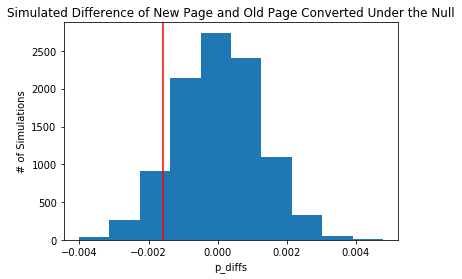

In [31]:
# Histogram of p_diffs
plt.hist(p_diffs)
plt.ylabel('# of Simulations')
plt.xlabel('p_diffs')
plt.title('Simulated Difference of New Page and Old Page Converted Under the Null');
plt.axvline(x=obs_diff, color='r');

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
prop = (p_diffs > obs_diff).mean()
print('The proportion of the p_diffs are greater than the actual difference = ',prop)

The proportion of the p_diffs are greater than the actual difference =  0.9054


k. Please explain using the vocabulary you've learned in this course what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**The one which was calculaed in 'j' called P-value. if the P-value less than (<0.5) would be rejecting the null-hypothesis. And more than this would be failed to reject the null-hypothesis. 
According to our P-value there is no statisical evidence to reject the null-hypothesis since the P-value = 0.905.**

l. We could also use a built-in to achieve similar results. Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let n_old and n_new refer the the number of rows associated with the old page and new pages, respectively.

In [48]:
convert_old = df2.query("landing_page == 'old_page' and converted==1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted==1").shape[0]
n_old = df2.query("landing_page == 'old_page'").shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0] 

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](https://docs.w3cub.com/statsmodels/generated/statsmodels.stats.proportion.proportions_ztest/) is a helpful link on using the built in.

In [34]:
# Caculating p-value and z-score
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new], alternative = 'smaller')
print('The Z-score is: ', z_score,' and the P-value is: ', p_value)

The Z-score is:  1.31092419842  and the P-value is:  0.905058312759


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**The Z-score is measures of standard deviation, Which indicates if the Z-score value between -1.96 and 1.96,  the P-value would be larger than (0.05). It would fail to reject the null hypothesis.** 

- The Z-score is (1.310)
- The P-value is (0.905)
- The P-value almost similar to the previous result.


**Based on the values, it failed to reject the null-hypothesis**

__[Reference](http://resources.esri.com/help/9.3/arcgisengine/java/gp_toolref/spatial_statistics_toolbox/what_is_a_z_score_what_is_a_p_value.htm)__ 

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Logistic Regression**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives. However, you first need to create in df2 a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [35]:
# Intercept column
df2['intercept'] = 1

# Create dummy variable 
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']

df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to instantiate your regression model on the two columns you created in part b., then fit the model using the two columns you created in part **b.** to predict whether or not an individual converts. 

In [36]:
#Loading Logit regression model
logit_mod = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
result = logit_mod.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [37]:
# Summary of the model
print(result.summary2())

                          Results: Logit
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-12 12:16 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074



e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in **Part II**?

**- The P-value associated with ab_page is 0.1899**

**In previous section we were trying to reject the null-hypothses but we couldn't because the P-value was 0.905. While in this section we checked if there is a significant difference in conversion based on which page a customer receives. Still tell us there is no that diffrence between old and new page.**

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**We should consider adding additional factors to the regression models. However, it might influence the result in direction that we don't know.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. You will need to read in the **countries.csv** dataset and merge together your datasets on the appropriate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [38]:
#Reading the countries
countries=pd.read_csv('countries.csv')
countries.head(3)

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK


In [39]:
# To check how many lebels 
countries['country'].unique()

array(['UK', 'US', 'CA'], dtype=object)

In [40]:
# Mergeing Dataframes
df3= df2.merge(countries, on ='user_id', how='left')
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US


In [41]:
# Create dummy variables
df3[['CA','US', 'UK']] = pd.get_dummies(df3['country'])[['CA','US', "UK"]]
df3.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,US,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0,US,0,1,0


In [42]:
# Create intercept variable
df3['intercept'] = 1

# Loading the Logit regression model for country and converted, and use CA as baseline
Model_Log = sm.Logit(df3['converted'], df3[['intercept','UK','US']])
result2 = Model_Log.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [43]:
# Print the result 
print (result2.summary2())

                          Results: Logit
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-12 12:16 AIC:              212780.8333
No. Observations:   290584           BIC:              212812.5723
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept     -2.0375    0.0260  -78.3639  0.0000  -2.0885  -1.9866
UK             0.0507    0.0284    1.7863  0.0740  -0.0049   0.1064
US             0.0408    0.0269    1.5178  0.1291  -0.0119   0.0935



- UK P-value: 0.0740
- US P-value: 0.1291
- Both are larger than 0.05

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [44]:
# New intereacton variable between page and country ( UK and US )
df3['UK_ab_page'] = df3['UK']*df3['ab_page']
df3['US_ab_page'] = df3['US']*df3['ab_page']

df3.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,US,UK,UK_ab_page,US_ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,1,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,1,0,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,0,0,1


In [45]:
# Loading Logit regression model
Model_Log = sm.Logit(df3['converted'], df3[['intercept','UK_ab_page','US_ab_page']])
result3 = Model_Log.fit()
# Print the result
print(result3.summary2())

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6
                          Results: Logit
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2020-11-12 12:16 AIC:              212781.7674
No. Observations:   290584           BIC:              212813.5064
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9926    0.0079  -252.9104  0.0000  -2.0081  -1.9772
UK_ab_page    0.0112    0.0179     0.6256  0.5316  -0.0240   0.0464
US_ab_page   -0.0144    0.0125    -1.1548  0.248

- The results in the summary of UK_ab_page and US_ab_page are larger than 0.05 value, which are not statistically significant.

- The intercept's p-value is less than 0.05, which is statistically significant enough for the converted rate.

- The country factor is not significant on the converted rate.

<a id='Conclusions'></a>
## Conclusions



All the P-values were more than 0.5. Therefore, we would fail to reject the null hypothesis. Also, there is not any sufficient evidence to suggest that the new page results have more conversions than the old page. Even after adding the countries variable did not lead to higher conversion for the new page.

**Reference:**
- __[Stackoverflow](https://stackoverflow.com)__ 
- __[Data Analysis Udacity Course](https://classroom.udacity.com/nanodegrees/nd002-connect/dashboard/overview)__ 

In [46]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0